In [1]:
from sklearn.datasets import make_classification
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

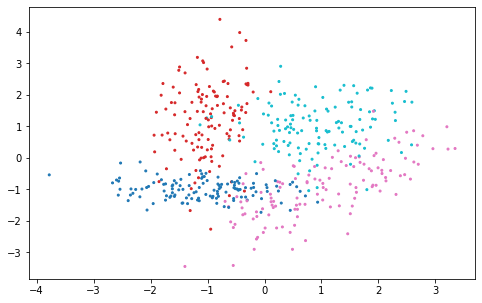

In [6]:
X, y = make_classification(
    n_samples = 500,
    n_features = 2, 
    n_classes = 4,
    n_clusters_per_class = 1,
    n_informative = 2,
    n_redundant = 0,
    random_state = 2023,
)

toy_data = pd.DataFrame(
    np.concatenate([X, y[:, np.newaxis]], 1),
    columns = ['x1','x2','y']
)


fig,ax = plt.subplots(figsize = (8,5))
ax.scatter(data = toy_data, x = 'x1', y = 'x2', c = 'y', cmap = 'tab10', s = 4)

In [3]:
from sklearn.model_selection import KFold

In [9]:
from sklearn.naive_bayes import GaussianNB as GNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC

gnb = GNB()
dt = DecisionTreeClassifier()
lr = LogisticRegression()
xgb = XGBClassifier(
    n_estimators = 100000,
    # gpu_id = 0,
    # tree_method = 'gpu_hist',
    learning_rate = 1e-2
)
svc = SVC(
    C = 1e+1, 
    degree = 2, 
    kernel = 'rbf',
)

In [ ]:
import torch
import pytorch_lightning as pl
import torchmetrics

In [ ]:
class pl_model(pl.LightningModule):
    def __init__(self, dims, lr = 1e-3, device = None):
        super().__init__()
            
        self.input_dims = dims
        self.output_dims = dims[1:]
        self.dims_flag = [False] * (len(self.output_dims) - 1) + [True]
        self._lr = lr
        
        self.build_model()
        
        self.loss_fn = torch.nn.CrossEntropyLoss()
        
        self.acc_fn = torchmetrics.Accuracy(num_classes = dims[-1])
        self.auc_fn = torchmetrics.AUROC(num_classes = dims[-1])
        self.f1_fn = torchmetrics.F1Score(num_classes = dims[-1], average = 'macro')
        
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), self._lr)

    
    def build_block(self, i, o, output_flag = False):
        if output_flag:
            return torch.nn.Linear(i,o)
        else:
            return torch.nn.Sequential(
                torch.nn.Linear(i, o),
#                 torch.nn.BatchNorm1d(o),
                torch.nn.ReLU(),
#                 torch.nn.Dropout(),
            )
    
    
    def build_model(self):
        nets = []
        for i,o,f in zip(self.input_dims, self.output_dims, self.dims_flag):
            print(i,o,f)
            nets.append(self.build_block(i,o,f))
        self.net = torch.nn.ModuleList(nets)

        
    def forward(self, x):
        for l in self.net:
            x = l(x)
        return x
    
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        
        acc = self.acc_fn(y_hat, y)
        self.log('train_acc', acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        
        auc = self.auc_fn(y_hat, y)
        self.log('train_auc', auc, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        
        f1 = self.f1_fn(y_hat, y)
        self.log('train_f1_macro', f1, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        
        return loss

            
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        loss = self.loss_fn(y_hat, y)
        self.log('valid_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        
        acc = self.acc_fn(y_hat, y)
        self.log('valid_acc', acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        
        auc = self.auc_fn(y_hat, y)
        self.log('valid_auc', auc, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        
        f1 = self.f1_fn(y_hat, y)
        self.log('valid_f1_macro', f1, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

    
    def predict_step(self, batch, batch_idx):
        return self(batch[0])

In [ ]:
dims = [df_arr.shape[1], 128, 128, 128, len(np.unique(Y))]
model = pl_model(dims)

In [11]:
from sklearn.metrics import accuracy_score
n_iter = 0
kfold = KFold(n_splits = 5, shuffle = True, random_state= 0)

for train_index, test_index in kfold.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    gnb.fit(X_train, y_train)

    gnb_pred = gnb.predict(X_test)
    n_iter += 1

    accuracy = np.round(accuracy_score(y_test, gnb_pred), 4)

    print('{} 번째. kfold 정확도 : {}, 학습데이터 크기 : {}, 검증데이터 크기 : {}'.format(n_iter, accuracy, X_train.shape[0], y_test.shape[0]))


1 번째. kfold 정확도 : 0.89, 학습데이터 크기 : 400, 검증데이터 크기 : 100
2 번째. kfold 정확도 : 0.83, 학습데이터 크기 : 400, 검증데이터 크기 : 100
3 번째. kfold 정확도 : 0.88, 학습데이터 크기 : 400, 검증데이터 크기 : 100
4 번째. kfold 정확도 : 0.85, 학습데이터 크기 : 400, 검증데이터 크기 : 100
5 번째. kfold 정확도 : 0.84, 학습데이터 크기 : 400, 검증데이터 크기 : 100
